## ANÁLISIS INICIAL DE LA ESTRUCTURA DE LOS DATOS

En este notebook se hace un análisis inicial de la estructura de los datos, para asegurar el tipo de preprocesamiento que debe aplicarse a la señal de EEG.

In [1]:
import os
import pylab
import mne.io
import mne
import os.path
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from TFG_utils import take_vmrk_filename
from TFG_utils import take_vhdr_filename
from TFG_utils import Get_Start_End
from TFG_utils import spot_samples
from TFG_utils import get_potencias
import pandas as pd
from TFG_utils import ratios

In [2]:
mne.__version__

'0.19.2'

El [formato de BrainVision](https://mne.tools/dev/auto_tutorials/io/plot_20_reading_eeg_data.html#brainvision-vhdr-vmrk-eeg) tiene una estructura divivida en los tres siguientes ficheros:

* La **cabecera (.vhdr)** del fichero  con los metadatos.

* Un archivo de **marcadores (.vmrk)** del texto con información sobre los eventos.

* Un archivo de **datos binarios (.eeg)** que contiene el valor de los voltajes del EEG.

Los datos de BrainVision pueden leerse con la [función mne.io.read_raw_brainvision()](https://mne.tools/dev/generated/mne.io.read_raw_brainvision.html#mne.io.read_raw_brainvision) con el fichero de cabecera (.vhdr) como input. Con esta función se obtiene un objeto en formato Raw que contiene todos los datos del fichero .eeg BrainVision. Con el [método get_data()](https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw) se extraen los datos del objeto Raw en microvoltios.

In [3]:
folder="eeg_example"
ch=1 #channel to represent

vmrk_filename = take_vmrk_filename(folder)
vhdr_filename = take_vhdr_filename(folder)

eeg_object = mne.io.read_raw_brainvision(vhdr_filename) # Leer los datos
eeg_data = eeg_object.get_data() # Cargar los datos

Extracting parameters from eeg_example\Neuromarketing3850.vhdr...
Setting channel info structure...


In [4]:
eeg_data

array([[ 0.0112562 ,  0.01138095,  0.01146259, ..., -0.0056125 ,
        -0.00452065, -0.00345244],
       [-0.20467211, -0.20452885, -0.20438803, ..., -0.16212165,
        -0.1620069 , -0.16186281],
       [-0.38860893, -0.38808203, -0.38787422, ..., -0.05965178,
        -0.05909641, -0.05837648],
       ...,
       [ 0.0710443 ,  0.07114235,  0.07131583, ...,  0.09422232,
         0.09451621,  0.09487764],
       [-0.11247817, -0.11238896, -0.11233695, ..., -0.15871242,
        -0.15764303, -0.15662648],
       [-0.0543197 , -0.05420066, -0.05413757, ..., -0.115281  ,
        -0.11416767, -0.11312777]])

### EEG_OBJECT

El objeto EEG contiene los datos del fichero .eeg y consiste en **31 canales** con alrededor de **240.000 muestras** obtenidas en un total de unos **480 segundos**. 

In [5]:
eeg_object

<RawBrainVision  |  Neuromarketing3850.eeg, n_channels x n_times : 31 x 240140 (480.3 sec), ~64 kB, data not loaded>

Para el estudio de los datos se usarán algunos atributos del objeto Raw como:
* **ch_names**: vector con el nombre de todos los canales
* **n_times**: indica el número de muestras de tiempo
* **times**: vector con todas las muestras de tiempo
* **info**: muestra información de todo lo que contiene el objeto

In [6]:
print('Hay', len(eeg_object.ch_names),'canales:', eeg_object.ch_names) # Número y nombre de los canales

Hay 31 canales: ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']


El número de **muestras de tiempo** indica el número de valores del registro eléctrico de EEG tendremos:

In [7]:
print('Hay',eeg_object.n_times,'muestras de tiempo') # Número de muestras de tiempo

Hay 240140 muestras de tiempo


In [8]:
print('El vector de muestras de tiempo es:',eeg_object.times) # Muestras de tiempo

El vector de muestras de tiempo es: [0.00000e+00 2.00000e-03 4.00000e-03 ... 4.80274e+02 4.80276e+02
 4.80278e+02]


In [9]:
info=eeg_object.info
info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : list | 31 items (EEG: 31)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 140.0 Hz
    meas_date : tuple | 2019-02-21 13:43:42 GMT
    nchan : int | 31
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType

In [10]:
info['chs'][:2]

[{'ch_name': 'Fp1',
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'logno': 1,
  'scanno': 1,
  'cal': 0.0488281,
  'range': 1e-06,
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit': 107 (FIFF_UNIT_V),
  'unit_mul': 0.0,
  'coord_frame': 4 (FIFFV_COORD_HEAD)},
 {'ch_name': 'Fz',
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'logno': 2,
  'scanno': 2,
  'cal': 0.0488281,
  'range': 1e-06,
  'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit': 107 (FIFF_UNIT_V),
  'unit_mul': 0.0,
  'coord_frame': 4 (FIFFV_COORD_HEAD)}]

In [11]:
info['sfreq']

500.0

### EEG_DATA

In [12]:
print(eeg_data) # Valores de cada muestra de tiempo para los 31 canales

[[ 0.0112562   0.01138095  0.01146259 ... -0.0056125  -0.00452065
  -0.00345244]
 [-0.20467211 -0.20452885 -0.20438803 ... -0.16212165 -0.1620069
  -0.16186281]
 [-0.38860893 -0.38808203 -0.38787422 ... -0.05965178 -0.05909641
  -0.05837648]
 ...
 [ 0.0710443   0.07114235  0.07131583 ...  0.09422232  0.09451621
   0.09487764]
 [-0.11247817 -0.11238896 -0.11233695 ... -0.15871242 -0.15764303
  -0.15662648]
 [-0.0543197  -0.05420066 -0.05413757 ... -0.115281   -0.11416767
  -0.11312777]]


In [13]:
print('Hay', eeg_data.shape[0], 'filas y', eeg_data.shape[1], 'columnas' ) # Forma de los datos

Hay 31 filas y 240140 columnas


Para coger información de los canales que nos interesen:

In [14]:
print(mne.pick_channels(info['ch_names'], include=['Fp1', 'Fz'])) # Cogemos dos
print(mne.pick_channels(info['ch_names'], include=[],exclude=['Fp1', 'Fz'])) # Quitamos dos

[0 1]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30]


### REPRESENTACIÓN GRÁFICA

Se busca el inicio y el final de los anuncios en el fichero de marcadores (vmrkr). Conociendo el momento en que empieza cada anuncio (en segundos), podemos obtener las muestras de los anuncios en cada uno de sus inicios. 

In [15]:
sfreq = info['sfreq']
start_end = Get_Start_End(vmrk_filename)
spots_times_sec = [0, 60, 120, 180, 226, 287, 347] # Time at which spot begins (in sec)
spot_samples = spot_samples(start_end,sfreq, spots_times_sec)

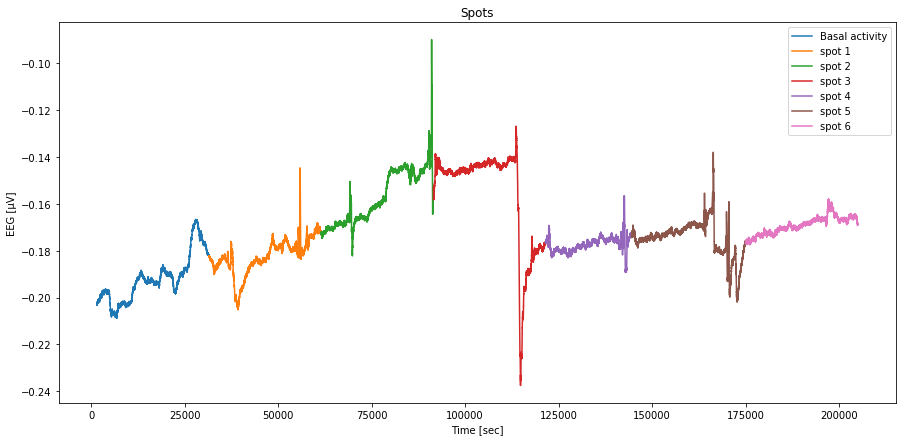

In [16]:
ini= int(60)*int(sfreq) # samples of 1st min of basal activity
i = 0

labels=['Basal activity','spot 1','spot 2','spot 3','spot 4', 'spot 5','spot 6']
plt.figure(figsize=(15,7))

axx=np.arange(spot_samples[i]-ini,spot_samples[i])
axy=eeg_data[ch,spot_samples[i]-ini:spot_samples[i]]
    
plt.plot(axx, axy, label=labels[i])

while i<(len(spot_samples)-1):
    axx=np.arange(spot_samples[i],spot_samples[i+1])
    axy=eeg_data[ch,spot_samples[i]:spot_samples[i+1]]
    plt.plot(axx, axy, label=labels[i+1])
    i+=1

plt.title('Spots')
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

Spot 1: ¿tendencia lineal?

Spot 2: muy grueso

¿Qué le pasa al spot 3?

### FILTRADO LINEAL

#### TENDENCIA LINEAL

In [17]:
eeg_dt= signal.detrend(eeg_data[ch],axis=-1,type='linear')

In [18]:
eeg_dt.shape

(240140,)

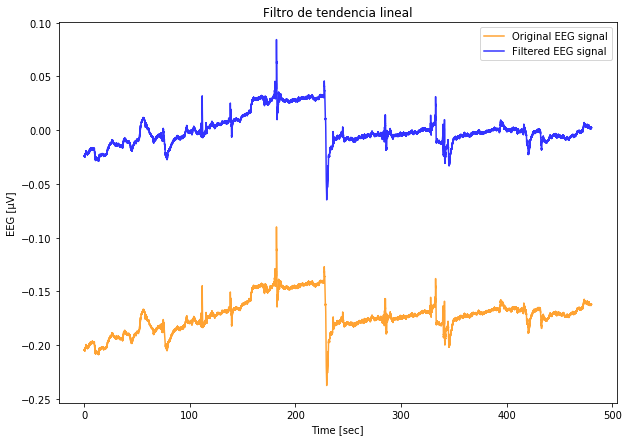

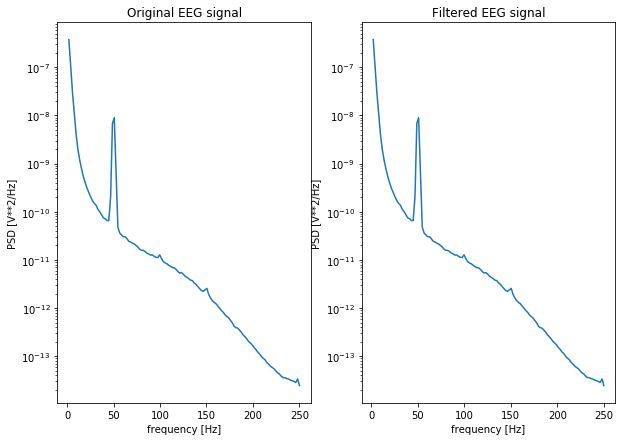

In [19]:
# EEG TIME PLOT
plt.figure(figsize=(10,7))
labels = ['Original EEG signal','Filtered EEG signal']

axx = eeg_object.times
y1 = eeg_data[ch]
y2 = eeg_dt

plt.plot(axx, y1, c='darkorange', label=labels[0], alpha=0.8)
plt.plot(axx, y2, c='blue', label=labels[1], alpha=0.8)

plt.title("Filtro de tendencia lineal")
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

# EEG FREQ PLOT
sig_list=[eeg_data[ch], eeg_dt]
fs=int(sfreq)

cont=0
fig = plt.figure(figsize=(10,7))
for sig in sig_list:
    cont+=1
    f, Px = signal.welch(sig, fs, window='hann') 
    plt.subplot(1,len(sig_list),cont)
    idx = []
    for i in f:
        if i>0:
            idx.append(True)
        else:
            idx.append(False)
            
    plt.semilogy(f[idx],Px[idx])
    plt.title(labels[cont-1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

#### NOTCH O RECHAZA BANDA

IIR

In [20]:
fs=int(sfreq)
f0 = 50  # Frequency to be removed from signal (Hz)
Q = 30  # Quality factor

b, a = signal.iirnotch(f0, Q, fs) # Design notch filter

In [21]:
eeg_notch = signal.filtfilt(b, a, eeg_data)# Apply notch filter

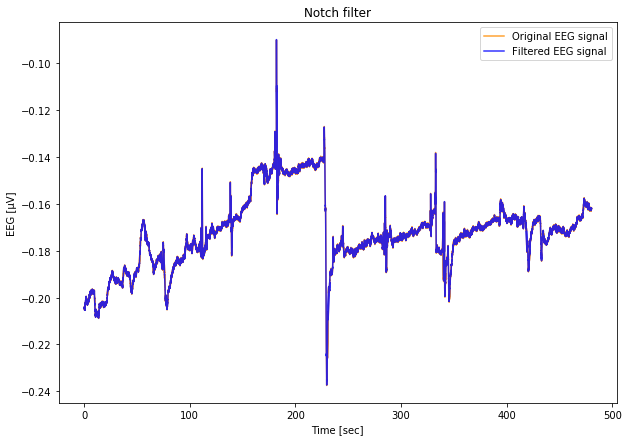

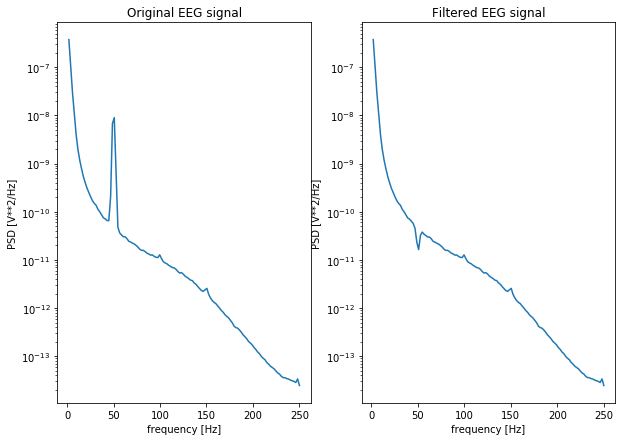

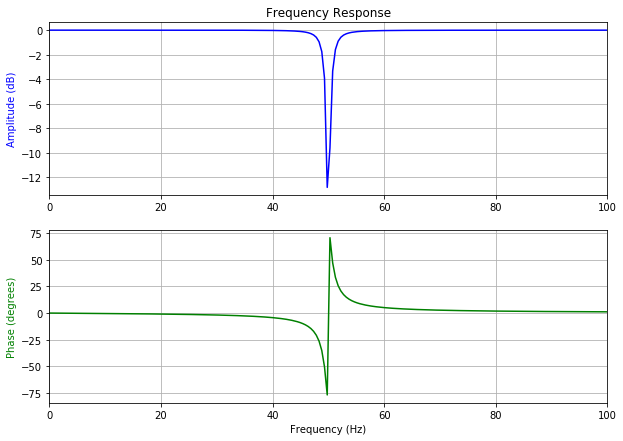

In [22]:
filtsig = eeg_notch
labels = ['Original EEG signal','Filtered EEG signal']

# EEG TIME PLOT
plt.figure(figsize=(10,7))

axx = eeg_object.times
axy1 = eeg_data[ch]
axy2 = filtsig[ch]

plt.plot(axx, axy1, c='darkorange', label=labels[0], alpha=0.8) #original signal
plt.plot(axx, axy2, c='blue', label=labels[1], alpha=0.8) #filtered signal

plt.title("Notch filter")
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

# EEG FREQ PLOT
sig_list=[eeg_data[ch],filtsig[ch]]
fs=int(sfreq)

cont=0
fig = plt.figure(figsize=(10,7))
for sig in sig_list:
    cont+=1
    f, Px = signal.welch(sig, fs, window='hann') 
    plt.subplot(1,len(sig_list),cont)
    idx = []
    for i in f:
        if i>0:
            idx.append(True)
        else:
            idx.append(False)
    plt.semilogy(f[idx],Px[idx])
    plt.title(labels[cont-1])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

# FREQUENCY RESPONSE
freq, h = signal.freqz(b, a, fs=fs)

fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
#ax[0].set_ylim([-15, 15])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Phase (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
#ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
#ax[1].set_ylim([-90, 90])
ax[1].grid()

plt.show()

#### PASO BANDA

FIR

In [23]:
fs=int(sfreq)
f1,f2 = (0.5,40)
numtaps= 70
b = signal.firwin(numtaps, [f1,f2], pass_zero=False ,fs=fs) # Get coefficients

In [24]:
eeg_bp = signal.filtfilt(b, 1, eeg_notch)

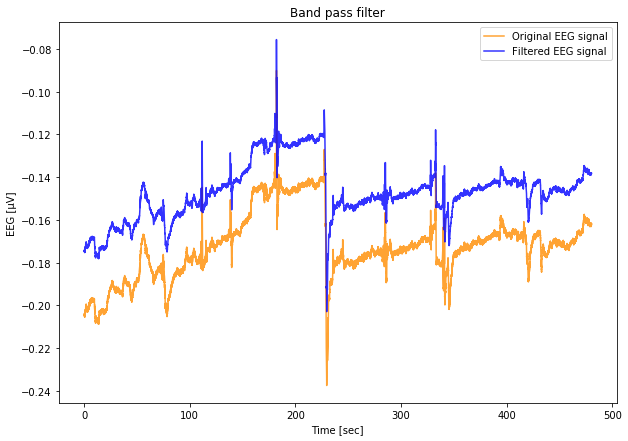

c:\users\noemi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.


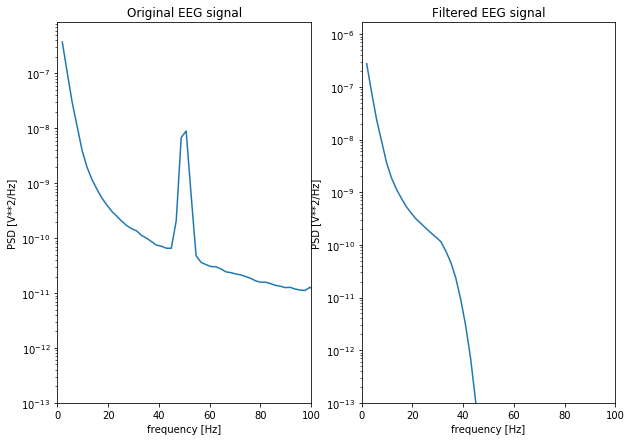

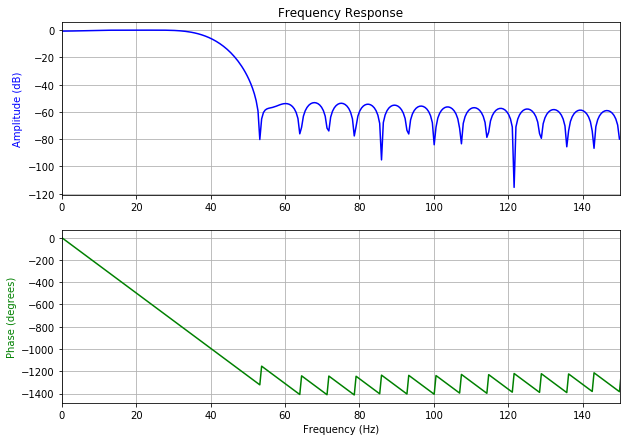

In [25]:
filtsig = eeg_bp
labels = ['Original EEG signal','Filtered EEG signal']

# EEG TIME PLOT
plt.figure(figsize=(10,7))

axx = eeg_object.times
axy1 = eeg_data[ch]
axy2 = filtsig[ch]

plt.plot(axx, axy1, c='darkorange', label=labels[0], alpha=0.8) # original signal
plt.plot(axx, axy2, c='blue', label=labels[1], alpha=0.8) # filtered signal

plt.title("Band pass filter")
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

# EEG FREQ PLOT
sig_list=[eeg_data[ch], filtsig[ch]]
fs=int(sfreq)

cont=0
fig = plt.figure(figsize=(10,7))
for sig in sig_list:
    cont+=1
    f, Px = signal.welch(sig, fs, window='hann') 
    plt.subplot(1,len(sig_list),cont)
    idx = []
    for i in f:
        if i>0:
            idx.append(True)
        else:
            idx.append(False)
    plt.semilogy(f[idx],Px[idx])
    plt.title(labels[cont-1])
    plt.xlim([0, 100])
    plt.ylim([0.0000000000001, 0])
    #plt.set_aspect('equal', adjustable='box')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

# FREQUENCY RESPONSE
freq, h = signal.freqz(b, 1, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 150])
#ax[0].set_ylim([-15, 15])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Phase (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 150])
#ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
#ax[1].set_ylim([-90, 90])
ax[1].grid()

plt.show()

IIR

In [26]:
N= 5 # Filter order
fs=int(sfreq)

f1,f2 = 8/fs,40/fs

b, a =signal.iirfilter(N,[f1,f2], btype='bandpass', ftype='butter')
eeg_bp = signal.filtfilt(b, a, eeg_notch)

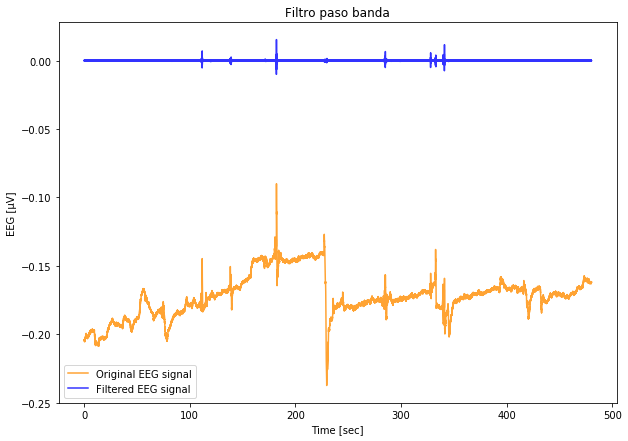

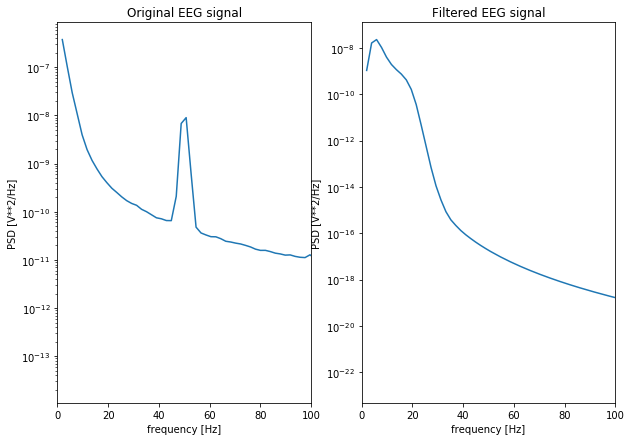

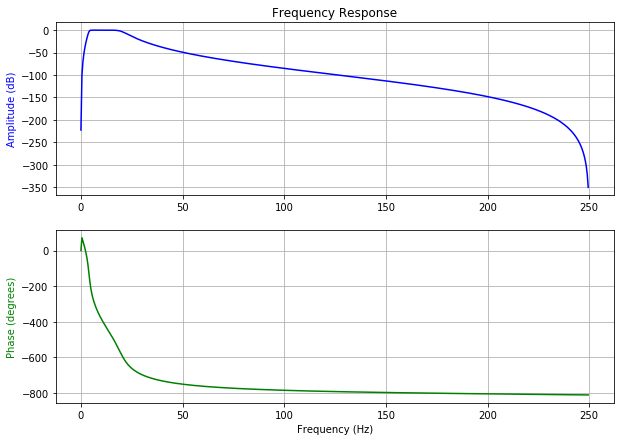

In [27]:
filtsig = eeg_bp
labels = ['Original EEG signal','Filtered EEG signal']

# EEG TIME PLOT
plt.figure(figsize=(10,7))

axx = eeg_object.times
axy1 = eeg_data[ch]
axy2 = filtsig[ch]

plt.plot(axx, axy1, c='darkorange', label=labels[0], alpha=0.8)
plt.plot(axx, axy2, c='blue', label=labels[1], alpha=0.8)

plt.title("Filtro paso banda")
plt.xlabel('Time [sec]')
plt.ylabel('EEG [µV]')
plt.legend(loc='best')
plt.show()

# EEG FREQ PLOT
sig_list=[eeg_data[ch], filtsig[ch]]
fs=int(sfreq)

cont=0
fig = plt.figure(figsize=(10,7))
for sig in sig_list:
    cont+=1
    f, Px = signal.welch(sig, fs, window='hann') 
    plt.subplot(1,len(sig_list),cont)
    idx = []
    for i in f:
        if i>0:
            idx.append(True)
        else:
            idx.append(False)
    plt.semilogy(f[idx],Px[idx])
    plt.title(labels[cont-1])
    plt.xlim([0, 100])
    #plt.ylim([0.0000000000001, 0])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')

# FREQUENCY RESPONSE
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
#ax[0].set_xlim([0, 100])
#ax[0].set_ylim([-15, 15])
ax[0].grid()

ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Phase (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
#ax[1].set_xlim([0, 100])
#ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
#ax[1].set_ylim([-90, 90])
ax[1].grid()

plt.show()

### FILTRADO NO LINEAL

#### ICA

In [31]:
info=eeg_object.info
ch_names = eeg_object.ch_names
ch_number = len(ch_names)
fs=info['sfreq']
info = mne.create_info(ch_names, fs, ch_types=["eeg"]*31)
raw = mne.io.RawArray(filtsig, info)
raw.set_montage("standard_1020")
raw_tmp = raw.copy()
raw_tmp.filter(1, None) # High Pass Filter

ica = mne.preprocessing.ICA(method="infomax", fit_params=dict(extended=True),random_state=1)
ica.fit(raw_tmp)

Creating RawArray with float64 data, n_channels=31, n_times=240140
    Range : 0 ... 240139 =      0.000 ...   480.278 secs
Ready.
DigMontage is a superset of info. 63 in DigMontage will be ignored. The ignored channels are: {'A2', 'F5', 'TP8', 'P1', 'PO9', 'PO4', 'PO2', 'AF7', 'FT8', 'PO3', 'M1', 'F6', 'PO5', 'C5', 'T6', 'AF6', 'AF10', 'PO6', 'O10', 'T10', 'PO7', 'P5', 'FCz', 'AF5', 'PO8', 'T3', 'PO1', 'POz', 'F2', 'A1', 'CPz', 'FC4', 'T4', 'AF3', 'O9', 'TP7', 'Iz', 'AF9', 'AF1', 'C2', 'CP3', 'CP4', 'F10', 'F1', 'P6', 'P9', 'AF4', 'Cz', 'P10', 'T5', 'AF8', 'C1', 'Fpz', 'F9', 'PO10', 'AFz', 'AF2', 'FC3', 'T9', 'C6', 'M2', 'FT7', 'P2'}
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ba

<ICA  |  raw data decomposition, fit (infomax): 240140 samples, 31 components, channels used: "eeg">

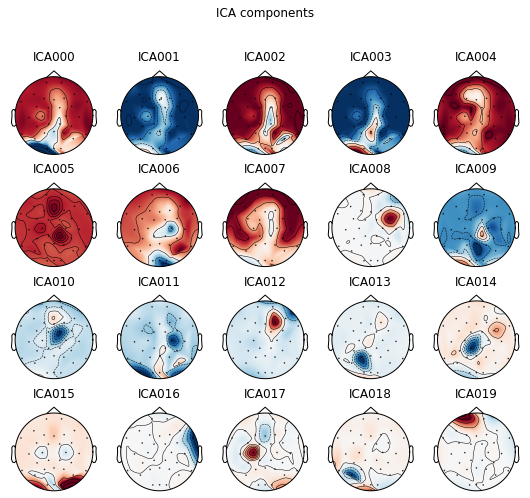

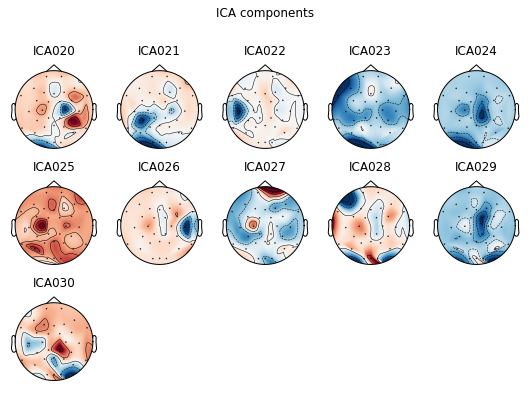

[<Figure size 540x504 with 20 Axes>, <Figure size 540x396 with 15 Axes>]

In [32]:
ica.plot_components(inst=raw_tmp)

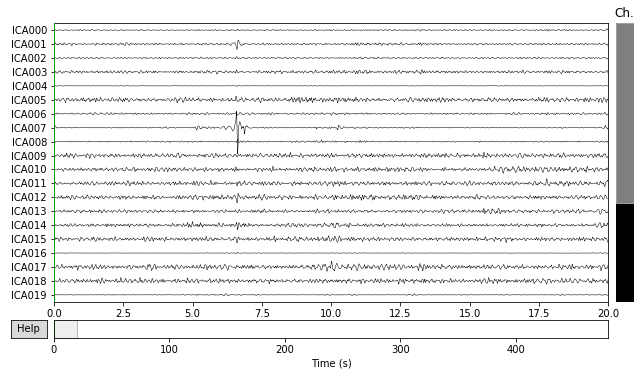

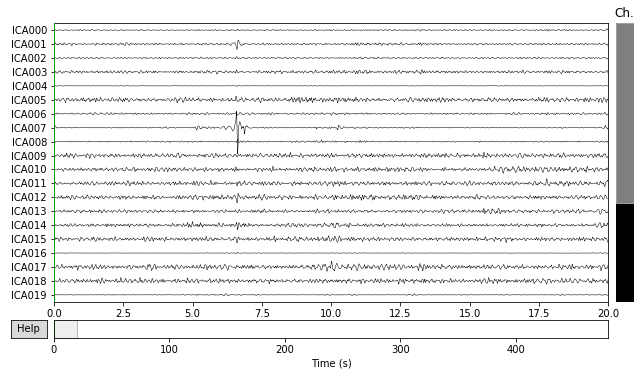

In [33]:
ica.plot_sources(inst=raw_tmp)

### PERIODOGRAMA

In [ ]:
ch=0
f, Px = signal.periodogram(eeg_data[ch], sfreq) 

plt.figure(figsize=(10,5))

idx = []
for i in f:
    if i>f1 and i<=f2:
        idx.append(True)
    else:
        idx.append(False)
        
#plt.plot(f[idx],Px[idx])
plt.semilogy(f[idx],Px[idx])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

print('La potencia total del periodograma en el intervalo 0.5-40 Hz es:',round(sum(Px[idx]),5))

POTENCIA EN LAS BANDAS DE FRECUENCIA

In [ ]:
v=4 #tamaño en seg de la ventana
L=int(v*sfreq) #tamaño en muestras de la ventana
m=int(0.5*sfreq) #avance de 0.5s en muestras
ch=0
num_ventanas=int((len(eeg_data[ch])-L)/m)

pot_bandas_alpha,pot_bandas_beta, pot_bandas_gamma, pot_ventanas = get_potencias(num_ventanas,eeg_data[ch],m,L,fs)

In [ ]:
dict = {"Pot ventana":pot_ventanas,"Pot alpha":pot_bandas_alpha, "Pot beta":pot_bandas_beta, "Pot gamma":pot_bandas_gamma}

Pot = pd.DataFrame(data = dict)
Pot.head()

Una vez obtenidas las potencias, creamos una función para calcular los ratios 

$ratio = \frac{Potencia Banda}{Potencia Total}$

In [ ]:
ratio_alpha, ratio_beta, ratio_gamma = ratios(Pot)

#%matplotlib notebook
plt.figure()        
plt.plot(ratio_alpha,'.-')
plt.plot(ratio_beta,'.-')
plt.plot(ratio_gamma,'.-')

plt.legend(['ratio alpha','ratio beta','ratio gamma'])
plt.xlabel('Ventanas de 4 seg')
plt.ylabel('Ratios')

#### ENLACES
https://mne.tools/dev/auto_tutorials/io/plot_20_reading_eeg_data.html#brainvision-vhdr-vmrk-eeg

https://mne.tools/dev/generated/mne.io.read_raw_brainvision.html#mne-io-read-raw-brainvision

https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw

https://mne.tools/dev/auto_tutorials/intro/plot_30_info.html#sphx-glr-auto-tutorials-intro-plot-30-info-py

https://www.frontiersin.org/articles/10.3389/fnins.2013.00267/full?source=post_page-----58aae90351e5----------------------